In [ ]:
pip install emoji

     |████████████████████████████████| 133kB 6.8MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/IFT6010/Projet
!ls 

/content/drive/MyDrive/IFT6010/Projet
 crypto_db.csv	    __pycache__				      stock_db.csv
 preprocessing.py  'Sentiment Analyzer-Neural Models.ipynb'


In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import re
import emoji
import time
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn import utils
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import ToktokTokenizer
np.random.seed(500) 

# Importing data 

In [ ]:
unprocessed_stocks = pd.read_csv("./stock_db.csv")
unprocessed_crypto = pd.read_csv("./crypto_db.csv")
unprocessed_stocks

,symbol,sentiment,message,message_id
0,AAPL,Bullish,$AAPL ain’t nobody selling. Shorts need to cov...,304543565
1,AAPL,Bullish,$QRVO today watch lists $CCIV $AAPL $RBLX,304543491
2,AAPL,Bullish,$AAPL could you imagine if we see $133+ by Fri...,304542855
3,AAPL,Bullish,$AAPL will revisit mid 126.xx\nWay too early i...,304542796
4,AAPL,Bullish,$AAPL \n\nBears are cocksuckers,304542546
...,...,...,...,...
291563,FB,Bullish,$FB I&#39;m excited about next week,19228876
291564,FB,Bullish,@flavisam_letstradeshares Agree re $fb,19228800
291565,FB,Bullish,$FB looking to test the 52w high at 58.96 (Jan9),19228632
291566,FB,Bullish,Recent sold $BBRY $IRWD $OREX $ACHN $LNKD $ANG...,19228264


In [ ]:
print(len(unprocessed_stocks))
print(len(unprocessed_crypto))

291568
305974


# Visualizing the data

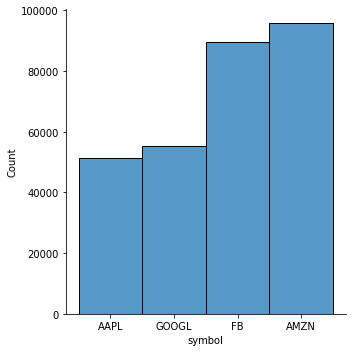

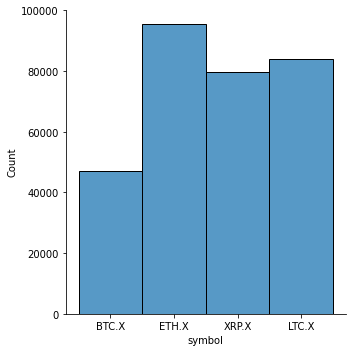

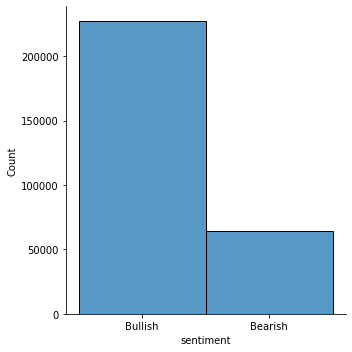

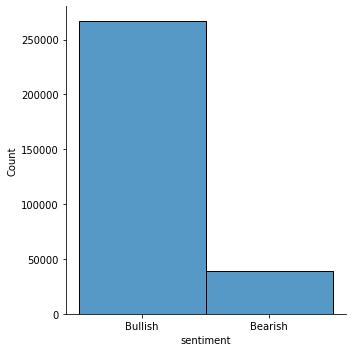

In [ ]:
sns.displot(unprocessed_stocks, x="symbol")
sns.displot(unprocessed_crypto, x="symbol")
sns.displot(unprocessed_stocks, x="sentiment")
sns.displot(unprocessed_crypto, x="sentiment")

# Preprocessing
Here we define our preprocess function, one needs to specify which preprocessing functions he wants to be applied to the data messages



In [ ]:
from preprocessing import preprocess

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
all_processed = pd.concat([unprocessed_crypto, unprocessed_stocks], ignore_index=True)
all_processed

,symbol,sentiment,message,message_id
0,BTC.X,Bullish,$BTC.X go go you beautiful bastard,304543745
1,BTC.X,Bullish,$ZIL.X $NIO $SSNLF $ETH.X $BTC.X \n\nhttps://t...,304543536
2,BTC.X,Bullish,$BTC.X Bitcoin is like real estate in Palm Bea...,304543059
3,BTC.X,Bearish,"$BTC.X dump city, dump dump city",304542929
4,BTC.X,Bullish,$AABB this baby about to 🚀🚀🚀$RIOT $MARA $FCEL ...,304542879
...,...,...,...,...
597537,FB,Bullish,$FB I&#39;m excited about next week,19228876
597538,FB,Bullish,@flavisam_letstradeshares Agree re $fb,19228800
597539,FB,Bullish,$FB looking to test the 52w high at 58.96 (Jan9),19228632
597540,FB,Bullish,Recent sold $BBRY $IRWD $OREX $ACHN $LNKD $ANG...,19228264


In [ ]:
%%time
all_processed = preprocess(all_processed, punc=False, lower=True, lemma=False, em_rep=True, num=False, stopw=False, misspell=False)
all_processed


CPU times: user 3min 48s, sys: 880 ms, total: 3min 49s
Wall time: 3min 49s


In [ ]:
all_processed['sentiment'].value_counts()

Bullish    494034
Bearish    103508
Name: sentiment, dtype: int64

In [ ]:
balanced_processed = all_processed.groupby('sentiment').apply(lambda x:x.sample(103508)).reset_index(drop=True)
print(balanced_processed['sentiment'].value_counts())


Bearish    103508
Bullish    103508
Name: sentiment, dtype: int64


In [ ]:
X_train, X_test= train_test_split(balanced_processed, test_size=0.3, random_state=500, stratify=balanced_processed['sentiment'])



In [ ]:
X_train

,symbol,sentiment,message,message_id
108597,LTC.X,Bullish,$ltc.x :rolling_on_the_floor_laughing: :rollin...,113751257
19325,AAPL,Bearish,$aapl i can’t believe i am saying this but aap...,283941970
107270,FB,Bullish,$tsla we are coming for $fb market cap and ove...,270163366
39765,XRP.X,Bearish,$xrp.x is in parabolic sar breakdown winning 6...,136086131
151350,AMZN,Bullish,$amzn i see this running up into prime day,246787120
...,...,...,...,...
41690,AAPL,Bearish,$aapl lol gamestop ! worth more than this pos ...,279087026
24281,GOOGL,Bearish,$aapl $amzn $nflx $fb $googl no matter how exp...,148420719
196889,AMZN,Bullish,"$amzn amazon to $3,300",232510511
169931,BTC.X,Bullish,$btc.x who bought dip? meeeeeeeeee!,126605568


# Word2Vec

In [ ]:
tok = ToktokTokenizer()
X_train['tokenized'] = X_train['message'].apply(tok.tokenize)
X_test['tokenized'] = X_test['message'].apply(tok.tokenize)
X_train

,symbol,sentiment,message,message_id,tokenized
108597,LTC.X,Bullish,$ltc.x :rolling_on_the_floor_laughing: :rollin...,113751257,"[$, ltc.x, :, rolling_on_the_floor_laughing, :..."
19325,AAPL,Bearish,$aapl i can’t believe i am saying this but aap...,283941970,"[$, aapl, i, can, ’, t, believe, i, am, saying..."
107270,FB,Bullish,$tsla we are coming for $fb market cap and ove...,270163366,"[$, tsla, we, are, coming, for, $, fb, market,..."
39765,XRP.X,Bearish,$xrp.x is in parabolic sar breakdown winning 6...,136086131,"[$, xrp.x, is, in, parabolic, sar, breakdown, ..."
151350,AMZN,Bullish,$amzn i see this running up into prime day,246787120,"[$, amzn, i, see, this, running, up, into, pri..."
...,...,...,...,...,...
41690,AAPL,Bearish,$aapl lol gamestop ! worth more than this pos ...,279087026,"[$, aapl, lol, gamestop, !, worth, more, than,..."
24281,GOOGL,Bearish,$aapl $amzn $nflx $fb $googl no matter how exp...,148420719,"[$, aapl, $, amzn, $, nflx, $, fb, $, googl, n..."
196889,AMZN,Bullish,"$amzn amazon to $3,300",232510511,"[$, amzn, amazon, to, $, 3,300]"
169931,BTC.X,Bullish,$btc.x who bought dip? meeeeeeeeee!,126605568,"[$, btc.x, who, bought, dip, ?, meeeeeeeeee, !]"


In [ ]:
from gensim.models import Word2Vec

In [ ]:
%%time
w2v = Word2Vec(sg=1, workers=4)
w2v.build_vocab([x for x in X_train["tokenized"]])

CPU times: user 4.95 s, sys: 86 ms, total: 5.04 s
Wall time: 5.05 s


In [ ]:
len(w2v.wv.vocab)

17272

In [ ]:
%%time
w2v.train([x for x in X_train["tokenized"]], total_examples=len(X_train), epochs=5)

CPU times: user 1min 39s, sys: 319 ms, total: 1min 40s
Wall time: 51.2 s


(10462608, 15343035)

In [ ]:
w2v.wv.__getitem__('facebook')

array([-0.32187364, -0.1882805 ,  0.09603991, -0.29279646,  0.6154981 ,
        0.08423149,  0.3359511 ,  0.1757769 , -0.03631771,  0.19796956,
        0.09968659,  0.12115879, -0.23813893,  0.46198577,  0.52837396,
       -0.06331854, -0.24015254, -0.38169113,  0.00247277, -0.10634353,
        0.27400902,  0.4248336 , -0.21461779, -0.09068631,  0.02784982,
        0.19124264,  0.11380766, -0.7830039 ,  0.27963108,  0.58689415,
       -0.1821404 ,  0.00184347,  0.5207437 ,  0.2621123 ,  0.20172295,
        0.36648026,  0.38801947,  0.10132634, -0.3238189 , -0.33392218,
        0.46476087, -0.22191215, -0.10137808, -0.09058888,  0.5122526 ,
       -0.15799142,  0.41600809, -0.25459853, -0.41339085, -0.1896944 ,
       -0.15721954, -0.10430812, -0.23219523, -0.10506119, -0.13313413,
        0.12626621, -0.540231  , -0.7115581 ,  0.471913  , -0.27300516,
        0.19786248, -0.253754  , -0.18796189,  0.02573824,  0.13650057,
       -0.21286485, -0.25685835, -0.06110866,  0.43582258, -0.07

In [ ]:
def get_mean_vector(word2vec_model, words):
    # remove out-of-vocabulary words
    words = [word for word in words if word in word2vec_model.wv.vocab]
    if len(words) >= 1:
        return np.mean(word2vec_model.wv.__getitem__(words), axis=0)
    else:
        return []
i = 0
mean_vectors = []
for blog in X_train['tokenized']:
    mean_vectors.append(get_mean_vector(w2v, blog))
    i+=1

i=0
mean_vectors2 = []
for blog in X_test['tokenized']:
    mean_vectors2.append(get_mean_vector(w2v, blog))
    i+=1

In [ ]:
len(mean_vectors)

144911

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR Accuracy Score Age->  72.22284840190001
CPU times: user 10 s, sys: 2.47 s, total: 12.5 s
Wall time: 6.94 s


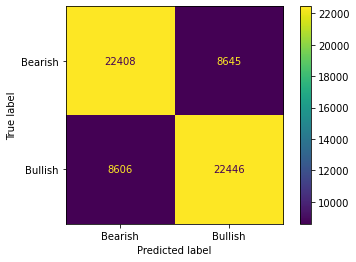

In [ ]:
%%time
# fit the training dataset on the classifier
LR = LogisticRegression()
LR.fit(mean_vectors, X_train['sentiment'])
# predict the labels on validation dataset
predictions_LR = LR.predict(mean_vectors2)
# Use accuracy_score function to get the accuracy
print("LR Accuracy Score Age-> ",accuracy_score(predictions_LR, X_test['sentiment'])*100)
plot_confusion_matrix(LR, mean_vectors2, X_test['sentiment'], values_format = '.5g')  

SVM Accuracy Score->  72.21801787295709
CPU times: user 35.8 s, sys: 389 ms, total: 36.2 s
Wall time: 35.9 s


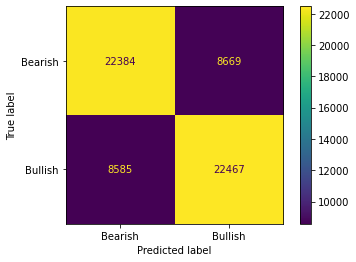

In [ ]:
%%time
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.LinearSVC()
SVM.fit(mean_vectors, X_train['sentiment'])
predictions_SVM = SVM.predict(mean_vectors2)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score-> ",accuracy_score(predictions_SVM, X_test['sentiment'])*100)
plot_confusion_matrix(SVM, mean_vectors2, X_test['sentiment'], values_format = '.5g')  

SVM Accuracy Score->  69.67554947266726


NameError: ignored

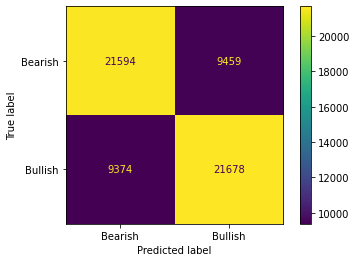

In [ ]:
%%time
KNN = KNeighborsClassifier()
KNN.fit(mean_vectors, X_train['sentiment'])
predictions_KNN = KNN.predict(mean_vectors2)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score-> ",accuracy_score(predictions_KNN, X_test['sentiment'])*100)
plot_confusion_matrix(KNN, mean_vectors2, X_test['sentiment'], values_format = '.5g') 
Metric(predictions_KNN, y_test) 

SVM Accuracy Score->  69.3358022703486
CPU times: user 4h 1min 55s, sys: 20.4 s, total: 4h 2min 15s
Wall time: 4h 1min 28s


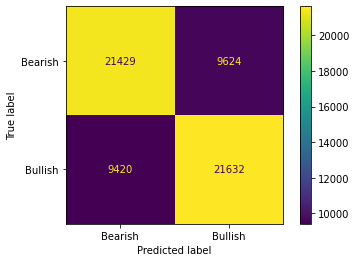

In [ ]:
%%time
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(kernel='linear')
SVM.fit(mean_vectors, X_train['sentiment'])
predictions_SVM = SVM.predict(mean_vectors2)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score-> ",accuracy_score(predictions_SVM, X_test['sentiment'])*100)
plot_confusion_matrix(SVM, mean_vectors2, X_test['sentiment'], values_format = '.5g')  